# GOOGLE stock 'Open' value prediction

In [1]:
# All libraries or module used

# Stock Data Extractor Libraries
import requests
import pandas_datareader as pdr
from pandas_datareader import data, wb

# Data Analysis Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Other Libraries
import pickle
import datetime
import math, time
from math import sqrt

# Scikit Learn Libraries
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

# Keras Libraries
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


In [21]:
# Getting and Saving The stock data of Google
# Splitting the data into training and testing data
symbol = "GOOG"
file_name = symbol+'_stock.csv' 

try:
    data_json = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey=S9PQXXDVL4Q5QDGX&datatype=csv&outputsize=full".format(symbol)
    page = requests.get(data_json)
    
    with open(file_name, 'wb') as file:
        file.write(page.content)
    dataframe = pd.read_csv(file_name, parse_dates=['timestamp'], index_col=['timestamp'])
    dataframe.sort_index(ascending=True, inplace=True)
except:
    dataframe = pd.read_csv(file_name, parse_dates=['timestamp'], index_col=['timestamp'])
    dataframe.sort_index(ascending=True, inplace=True)
    
train_length = int(0.7 * len(dataframe))
df_train = dataframe.iloc[:train_length,[0, 3]]
df_test = dataframe.iloc[train_length:,[0, 3]]
# df_train = pd.read_csv('GOOG_train.csv', index_col = ['Date'], parse_dates = ["Date"], usecols = ['Date', 'Open', 'Close'])
# df_train.sort_index(ascending=True, inplace=True)
# df_test = pd.read_csv('GOOG_test.csv', index_col = ['Date'], parse_dates = ["Date"], usecols = ['Date', 'Open', 'Close'])
# df_test.sort_index(ascending=True, inplace=True)

## Loading GOOGL stock data from Quandl.com

In [22]:
# normalizing data by dividing 1000
df_train = df_train / 1000
df_test = df_test / 1000

## It is set to calculate the first feature as a result.

In [23]:
# Generating training and testing data for feature and label 
# i.e. Xtrain, ytrain, Xtest, ytest
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len
    result = []
    
    row = round(0.9 * data.shape[0])
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for index in range(len(data)):
        if index < row:
            X_train.append(data[index])
            y_train.append(data[index + 1])
        else:
            X_test.append(data[index])
            y_test.append(data[index])
            
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

#     result = np.array(result)
#     row = round(0.9 * result.shape[0])
#     train = result[:int(row), :]
    
#     print(train[0])
    
#     x_train = train[:, 0]
#     y_train = train[:, 1][:,0]
#     x_test = result[int(row):, 0]
#     y_test = result[int(row):, 1][:, 0]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]


def training_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    #data_open = stock_open.as_matrix()
    
    X_train = []
    y_train = []
    
    for index in range(seq_len, len(data)):
            X_train.append(data[index - seq_len:index])
            y_train.append(data[index][0])
            
    X_train, y_train= np.array(X_train), np.array(y_train)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    
    return X_train, y_train

def testing_data(stocks_train, stock_test, seq_len):
    amount_of_features = len(stock_test.columns)
    try:
        data = stock_test.open
    except:
        data = stock_test.Open
    
    X_test = []    
    y_test = data.as_matrix()
    
    dataset_total = pd.concat((stocks_train, stock_test), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(stock_test) - seq_len:].as_matrix()
    
    for index in range(seq_len, len(stock_test) + seq_len):
        X_test.append(inputs[index - seq_len:index])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))
    
    return X_test, y_test

## Building model functions

In [24]:
# Defining Model Structure
def build_model(layers):
        d = 0.3
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [25]:
window = 1
X_train, y_train = training_data(df_train, window)
X_test, y_test = testing_data(df_train, df_test, window)
print("\n")
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)



X_train (708, 1, 2)
y_train (708,)
X_test (305, 1, 2)
y_test (305,)


## Loading the model sequence structure

In [26]:
# Building the model sequence structure
model = build_model([len(df_train.columns),window,1])

## Executing the model & RMS/RMSE results

In [27]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

In [28]:
# Getting the Accuracy of training data (Performance metric --> MSE)
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

# Getting the Accuracy of testing data (Performance metric --> MSE)
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [29]:
# for diffrence between actual value and predicted value 
# and ratio of actual value to the predicted value
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

## Predictions vs Real results

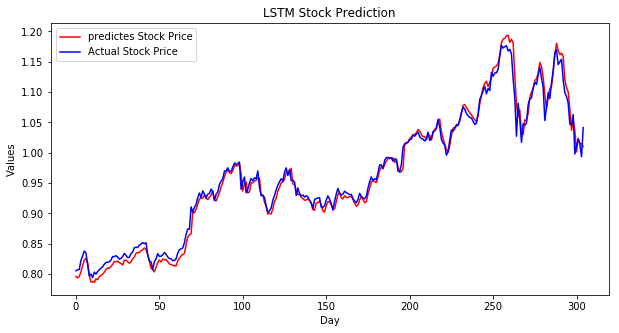

In [30]:
# plotting the Actual vs Predicted Result
plt.figure(figsize=(10, 5))
plt.plot(p,color='red', label='predictes Stock Price')
plt.plot(y_test,color='blue', label='Actual Stock Price')
plt.legend(loc='upper left')
plt.xlabel("Day")
plt.ylabel("Values")
plt.title("LSTM Stock Prediction")
plt.show()

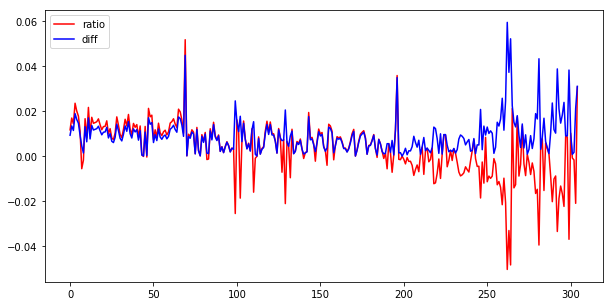

In [31]:
# plotting the difference and ratio of actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(ratio,color='red', label='ratio')
plt.plot(diff,color='blue', label='diff')
plt.legend(loc='upper left')
plt.show()

In [32]:
np.mean(np.abs(p - y_test.reshape(-1, 1)) < 0.02)

0.93770491803278688

In [33]:
print(df_test.tail(10), X_test[-10:], y_test.reshape(-1, 1)[-10:], p[-10:])

               open    close
timestamp                   
2018-03-22  1.08188  1.04908
2018-03-23  1.04703  1.02157
2018-03-26  1.04600  1.05321
2018-03-27  1.06300  1.00510
2018-03-28  0.99800  1.00456
2018-03-29  1.01163  1.03179
2018-04-02  1.02282  1.00647
2018-04-03  1.01391  1.01341
2018-04-04  0.99341  1.02514
2018-04-05  1.04133  1.02781 [[[ 1.09274  1.09088]]

 [[ 1.08188  1.04908]]

 [[ 1.04703  1.02157]]

 [[ 1.046    1.05321]]

 [[ 1.063    1.0051 ]]

 [[ 0.998    1.00456]]

 [[ 1.01163  1.03179]]

 [[ 1.02282  1.00647]]

 [[ 1.01391  1.01341]]

 [[ 0.99341  1.02514]]] [[ 1.08188]
 [ 1.04703]
 [ 1.046  ]
 [ 1.063  ]
 [ 0.998  ]
 [ 1.01163]
 [ 1.02282]
 [ 1.01391]
 [ 0.99341]
 [ 1.04133]] [[ 1.10022914]
 [ 1.07096517]
 [ 1.03692329]
 [ 1.05396128]
 [ 1.03633046]
 [ 1.0013448 ]
 [ 1.02364945]
 [ 1.01561856]
 [ 1.01470184]
 [ 1.01024961]]


In [34]:
try:
    all_data = np.append(df_train['Open'].values, df_test['Open'].values)
    all_data = np.append(all_data, model.predict(np.array([df_test.values[-window:]])))
    all_data
except:
    all_data = np.append(df_train['open'].values, df_test['open'].values)
    all_data = np.append(all_data, model.predict(np.array([df_test.values[-window:]])))
    all_data

all_data

array([ 0.568     ,  0.5612    ,  0.56689   , ...,  0.99341   ,
        1.04133   ,  1.03733444])

In [35]:
# Saving the training, testing, and window size
# Also Saving the model 
joblib.dump(df_train, "training_data.pkl")
joblib.dump(df_test, "testing_data.pkl")
joblib.dump(window, "actual_window.pkl")
model.save('modd.hdf5')